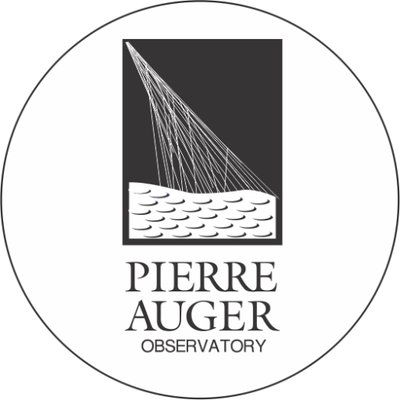
# Large-scale anisotropy study of data from the Pierre Auger Observatory

<i>Notebook released together with the Pierre Auger Observatory Open Data release 2021 (<a href="https://doi.org/10.5281/zenodo.4487612">DOI 10.5281/zenodo.4487612</a>). More information at the <a href="https://www.auger.org/opendata/">Auger open data website</a>.</i>

This jupyter notebook loads the data released by the Pierre Auger Collaboration and displays on the sphere the arrival directions of events above a threshold energy ($E > E_{\rm min}$). A Rayleigh analysis in right ascension is performed, whose results can be compared with those published in The Pierre Auger Collaboration (2017), Science 357, 6357, 1266, https://science.sciencemag.org/content/357/6357/1266, https://arxiv.org/abs/1709.07321. 

In [1]:
%matplotlib inline

from IPython.display import HTML, Latex, Math, display

# Data analysis
import numpy as np
import pandas as pd

# Create spherical-map
import healpy as hp

# Manage & convert astro coordinates
import astropy.units as u
import astropy.coordinates as Coord

# Tools for Rayleigh analysis
from scipy.optimize import minimize, least_squares, curve_fit
from scipy.stats import chi2
from scipy.special import erfcinv

# Plotting
import matplotlib
from matplotlib import rcParams
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
# Data loading, encapsulated to make it less installation and OS dependant
import os.path
from zipfile import ZipFile
def AugerLoad(fdir,file):
    """
    Loads a file from the auger open data release. Can be either in the local directory,
    in the parent directory or in the augeropendata directory.
    File is identified by it directory *fdir* and filename *file* and can be found in the directory
    or in a zip file.
    """
    for loc in [".","..","augeropendata"]:
        fname=os.path.join(loc,fdir,file)
        if os.path.isfile(fname):
            return open(fname)
        zname=os.path.join(loc,fdir+".zip")
        if os.path.isfile(zname):
            with ZipFile(zname) as myzip:
                return myzip.open(os.path.join(fdir,file))


## Loading the dataset

The released data can be retrieved from the git directory: https://gitlab.com/auger-observatory/drt/csvfiles. Ten percent of the data accumulated by the Pierre Auger Observatory are stored in the file "dataSummary.csv" which contains, among many pieces of information, the energy, the Galactic & equatorial coordinates of each event and the value of the exposure at the arrival time of the event. The released events have been selected below a zenith angle $60^\circ$ and above an energy $E>2.5$ EeV, for which the full efficiency of the surface detector is reached.
We load below the dataset.

In [3]:
# Load data
raw_data = pd.read_csv(AugerLoad('summary','dataSummary.csv'))

We select the relevant columns for the anisotropy analysis and print out the characteristics of one random event in the dataset.

In [4]:
# Safeguard: select only events above Eth = 2.5 EeV, where full efficiency is reached for zenith angles < 60°
Eth = 2.5 # EeV
e_cut = (raw_data.sd_energy>Eth)
data = raw_data[e_cut]
totalExposure = data.sd_exposure.iloc[-1]

# Example: print the energy and the galactic coordinates of a randomly selected event
event = np.random.randint(0, data.shape[0])
example = data.iloc[event]

display(Latex(f'''Event #{event}:
\\begin{{align}}
E &= {example.sd_energy}\\,\\mathrm{{EeV}}\\\\
l &= {example.sd_l} ^\circ\\\\
b &= {example.sd_b} ^\circ\\\\
\\end{{align}}
'''))

<IPython.core.display.Latex object>

## Healpy coordinates

The `healpy` package, which is based on the C++ library `HEALPix` (https://healpy.readthedocs.io/), is used to bin the data on the celestial sphere.

`HEALPix` uses classical spherical coordinates ($\theta, \phi$) that are directly linked to Galactic coordinates ($l = \phi_{\rm G}$, $b = 90^\circ - \theta_{\rm G}$), where the Galactic Center ($l = 0^\circ$, $b = 0^\circ$) is at the origin, or to equatorial coordinates ($\alpha = \phi_{E} - 180^\circ$, $\delta = 90^\circ - \theta_{\rm E}$), where ($\alpha = 180^\circ$, $\delta = 0^\circ$) is at the origin. We define in the raw code the function `HealpyCoordToMap`, which converts the spherical coordinates used by `HEALPix` ($\phi$, $\theta$) to Galactic coordinates (l,b) if `galCoord == True`, or to equatorial coordinates ($\alpha$, $\delta$) if `galCoord == False`. The inverse function `MapToHealpyCoord` is also defined. 

The function `LoadShapedData` loads the arrival directions of events above an energy threshold, $E_{\rm min}$, and returns a shaped dataset stored in a single Pandas DataFrame.

In [5]:
def MapToHealpyCoord(galCoord, l, b):
    
    theta = np.pi/2 - b
    phi = l

    if(not galCoord): # If equatorial coordinates
        phi -= np.pi
    return phi, theta

def HealpyCoordToMap(galCoord, phi, theta):
    
    b = np.pi/2 - theta
    l = phi
    if(not galCoord): # If equatorial coordinates: l+π, projected to [0, 2*π]
        l = np.where(l < np.pi, l + np.pi, l - np.pi) 
    return l, b


def LoadShapedData(galCoord = False, Emin = 8):
    
    # Coordinate conversion, returns (phi, theta)
    coords = MapToHealpyCoord(galCoord,
                              np.radians(data.sd_l if galCoord else data.sd_ra),
                              np.radians(data.sd_b if galCoord else data.sd_dec))

    # Event selection above Emin
    unmasked = (data.sd_energy>Emin)
    dataset = pd.DataFrame(dict(zip(['phi', 'theta'], coords)))[unmasked]
    return dataset

## Count map

A `HEALPix` map is defined by the size of its binning through the parameter `NSIDE` (generally a power of 2, see https://lambda.gsfc.nasa.gov/toolbox/tb_pixelcoords.cfm). The function `LoadCountMap` stores arrival directions of events with an energy above a user-defined threshold energy, $E_\mathrm{min}$, into a `HEALPix` map (a 1D numpy array). The function `PlotHPmap` displays, using `matplotlib`, the map in the chosen coordinate system, as illustrated below.

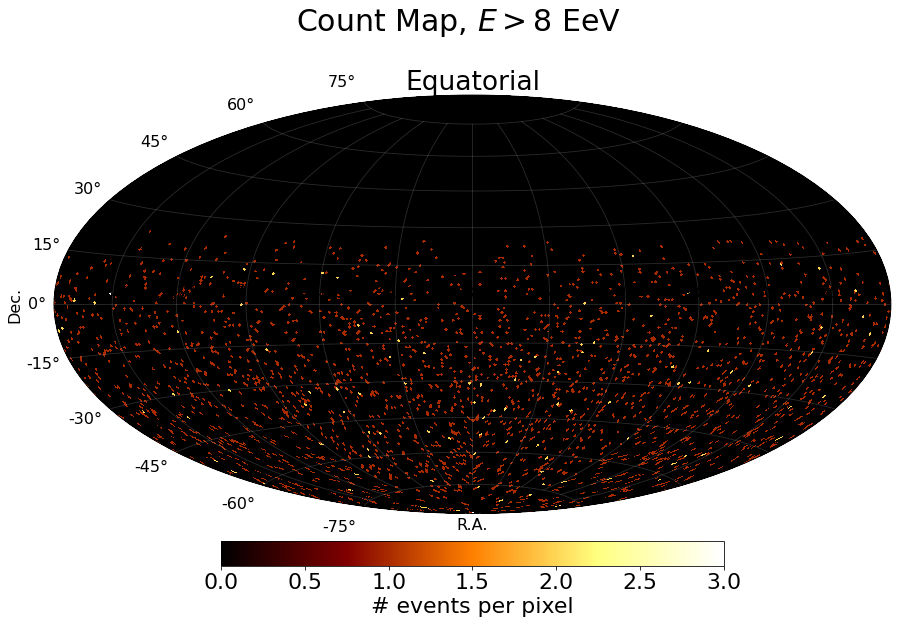

In [6]:
def LoadCountMap(dataset, nside):
    
    # Pixel index for each events of coordinates (theta, phi)
    index = hp.ang2pix(nside, dataset.theta, dataset.phi)

    # Count map of parameter nside
    npix = hp.nside2npix(nside)# npix corresponds to the number of pixel associated to a NSIDE healpy map
    count_map = np.histogram(index, bins=np.arange(npix + 1))[0]
    
    return count_map

def PlotHPmap(HPmap, nside, galCoord, title, color_bar_title, projection="hammer", cmap='afmhot', vmin=None, vmax=None, fig=None, ax=None):
    
    # Transform healpix map into matplotlib map (grid_map)
    xsize = 2000 # grid size for matplotlib
    ysize = int(xsize/2.)
    theta = np.linspace(np.pi, 0, ysize)
    phi   = np.linspace(-np.pi, np.pi, xsize)
    PHI, THETA = np.meshgrid(phi, theta)
    grid_pix = hp.ang2pix(nside, THETA, PHI)
    grid_map = HPmap[grid_pix]

    # Define the figure
    width = 15# width of the figure
    if fig is None:
        doubleFig = False
        fig = plt.figure(figsize=(width,width/1.5))
        fig.suptitle(title, size=30)
    else:
        doubleFig = True
    if ax is None:
        ax = fig.add_subplot(111, projection=projection)
    labelsize = 16
    ax.tick_params(axis='x', labelsize=labelsize)
    ax.tick_params(axis='y', labelsize=labelsize)
            
    # Set the size of the other fonts
    fontsize = 22
    font = {'size': fontsize}
    matplotlib.rc('font', **font)
    
    # minimum and maximum values along the z-scale (colorbar)
    if vmax is None:
        vmax = np.max(HPmap)
    if vmin is None:
        vmin = np.min(HPmap)   
    
    # Plot the map, reverse the longitude axis "[::-1]" (astronomical convention)
    longitude = np.radians(np.linspace(-180, 180, xsize))
    latitude = np.radians(np.linspace(-90, 90, ysize))
    image = ax.pcolormesh(longitude[::-1], latitude, grid_map, rasterized=True, 
                          cmap=plt.get_cmap(cmap), shading='auto', vmin=vmin, vmax=vmax)
    if not doubleFig:
        cb = fig.colorbar(image, orientation='horizontal', shrink=.6, pad=0.05)
        cb.set_label(color_bar_title, size=fontsize)
    
    # Plot the labels considering if it is galactic or equatorial coordinates
    if(galCoord):
        ax.set_xticklabels([r"150$\degree$", r"120$\degree$", r"90$\degree$", r"60$\degree$", r"30$\degree$", r"GC", r"330$\degree$", r"300$\degree$", r"270$\degree$", r"240$\degree$", r"210$\degree$"])
        ax.set_title("Galactic")
        ax.set_xlabel('l', size=labelsize)
        ax.set_ylabel('b', size=labelsize)
    else:
        ax.set_xticklabels([r"330$\degree$", r"300$\degree$", r"270$\degree$", r"240$\degree$", r"210$\degree$", r"180$\degree$", r"150$\degree$", r"120$\degree$", r"90$\degree$", r"60$\degree$", r"30$\degree$"])
        ax.set_title("Equatorial")
        ax.set_xlabel('R.A.', size=labelsize)
        ax.set_ylabel('Dec.', size=labelsize)
        
    ax.grid(True, alpha=0.25)

    if doubleFig:
        return image

# Plot the count map
Emin = 8 # EeV
galCoord = False
dataset = LoadShapedData(galCoord, Emin) # data Emin

nside = 64
count_map = LoadCountMap(dataset, nside)

title=f"Count Map, $E > {Emin}$ EeV"
color_bar_title = "# events per pixel"
PlotHPmap(count_map, nside, galCoord, title, color_bar_title)

## Exposure map

The exposure of the Pierre Auger Observatory surface detector is purely geometric (see Sommers P., Astroparticle Physics 2001, 271 - https://www.sciencedirect.com/science/article/abs/pii/S0927650500001304?via%3Dihub, https://arxiv.org/abs/astro-ph/0004016) and depends on declination in equatorial coordinates. $\tt Astropy$ (https://www.astropy.org/) is used here to switch from equatorial coordinates to Galactic coordinates when needed.

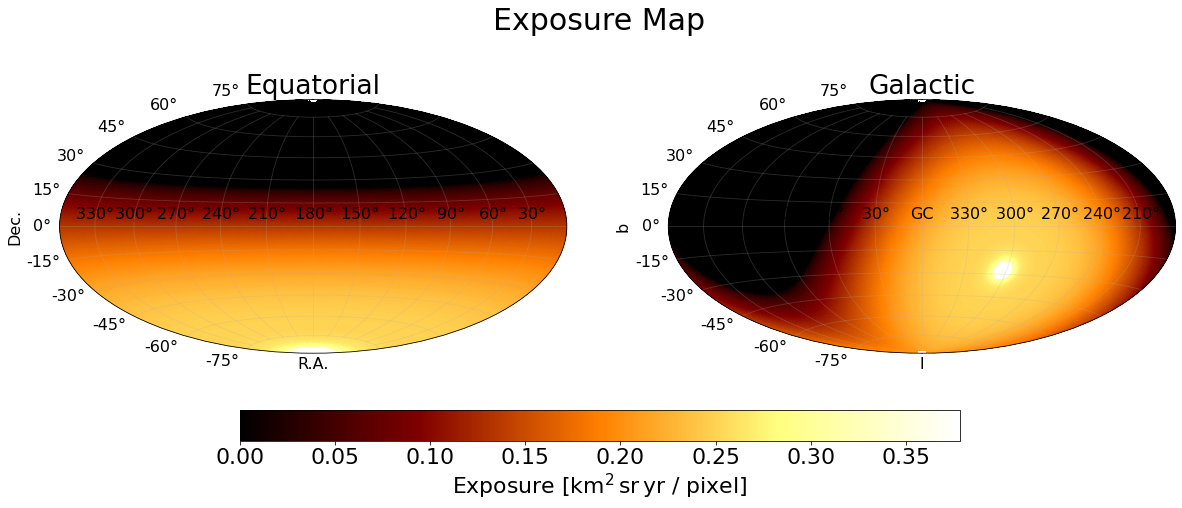

In [7]:
def exposure(dec):
    
    theta_max = np.radians(60) # Maximum zenith angle in the dataset
    l = np.radians(-35.23) # Latitude of the center of the array (near Malargüe - Argentina)
    
    arg = (np.cos(theta_max) - np.sin(l)*np.sin(dec)) / (np.cos(l)*np.cos(dec))
    hm = np.arccos(arg.clip(-1, 1))

    return np.cos(l)*np.cos(dec)*np.sin(hm) + hm*np.sin(l)*np.sin(dec)

def Get_ra_dec(nside, galCoord):
    
     # Get the healpy coordinates of each pixel 
    npix = hp.nside2npix(nside)
    phi, theta = hp.pix2ang(nside, np.arange(npix))

    # Transform the (y,x) values into whether galactic coordinates or whether equatorial coordinates.
    if(galCoord): #If galactic coordinates, get the declination value for a given (l,b)
        l, b = HealpyCoordToMap(True, theta, phi)
        c = Coord.SkyCoord(l=l*u.radian, b=b*u.radian, frame='galactic')
        ra = c.icrs.ra.radian
        dec = c.icrs.dec.radian
    else:
        ra, dec  = HealpyCoordToMap(False, theta, phi)
        
    return ra, dec

def LoadExposureMap(totalExposure, nside, galCoord):
   
    ra, dec = Get_ra_dec(nside, galCoord)
    
    # Compute the exposure_map for each pixel regarding its declination.
    exposure_map = exposure(dec)*totalExposure/np.sum(exposure(dec))
    
    return exposure_map


# Compute the exposure in equatorial coordinates & save the figure in a file "equatorial.jpg"
nside = 64
title = "Exposure Map"
color_bar_title = r"Exposure [$\rm km^{2} \, sr \, yr$ / pixel]"


# Plot the two exposure map
rcParams['figure.figsize'] = 20, 14 #Size of figs
fig, ax = plt.subplots(1, 2, subplot_kw={'projection': 'hammer'})
fig.suptitle(title, fontsize=30)

for galCoord in [0, 1]:
    exposure_map = LoadExposureMap(totalExposure, nside, galCoord)
    image = PlotHPmap(exposure_map, nside, galCoord, title, color_bar_title, ax=ax[galCoord], fig=fig)

fig.subplots_adjust(top=1.4)
cbar_ax = fig.add_axes([0.25, 0.55, 0.5, 0.03])
cb = fig.colorbar(image, orientation='horizontal', shrink=.6, pad=0.05, cax=cbar_ax)
cb.set_label(color_bar_title, size=22)


plt.show()

## Smoothed count and exposure maps

One may wish to display smoothed maps to highlight features on a specific angular scale. A top-hat smoothing with a 45° radius is used here, as in The Pierre Auger Collaboration, Science 357, 6357, 1266, https://science.sciencemag.org/content/357/6357/1266, https://arxiv.org/abs/1709.07321. Both the energy threshold and the smoothing radius can be changed by the user.

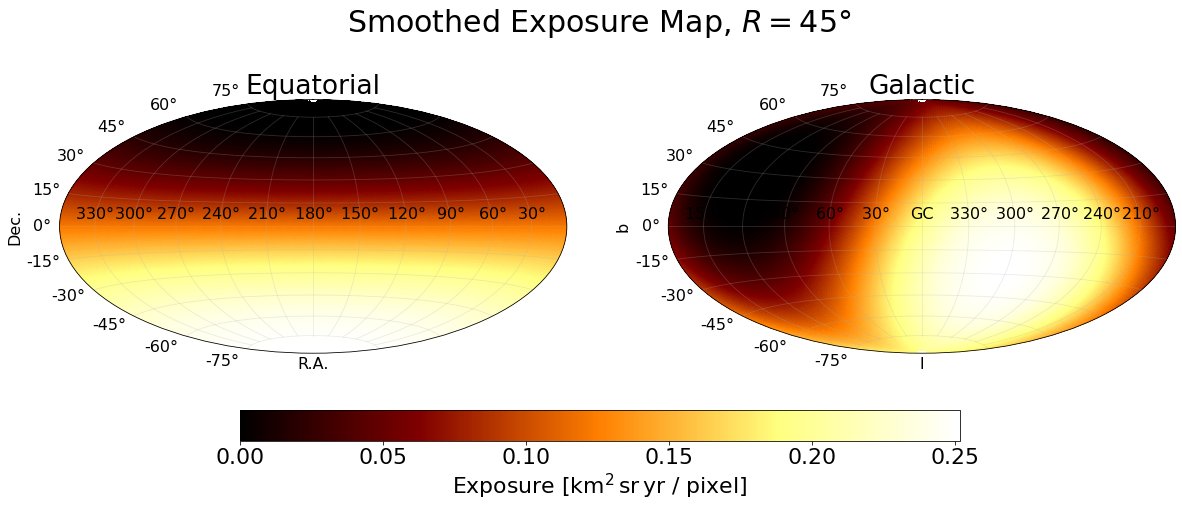

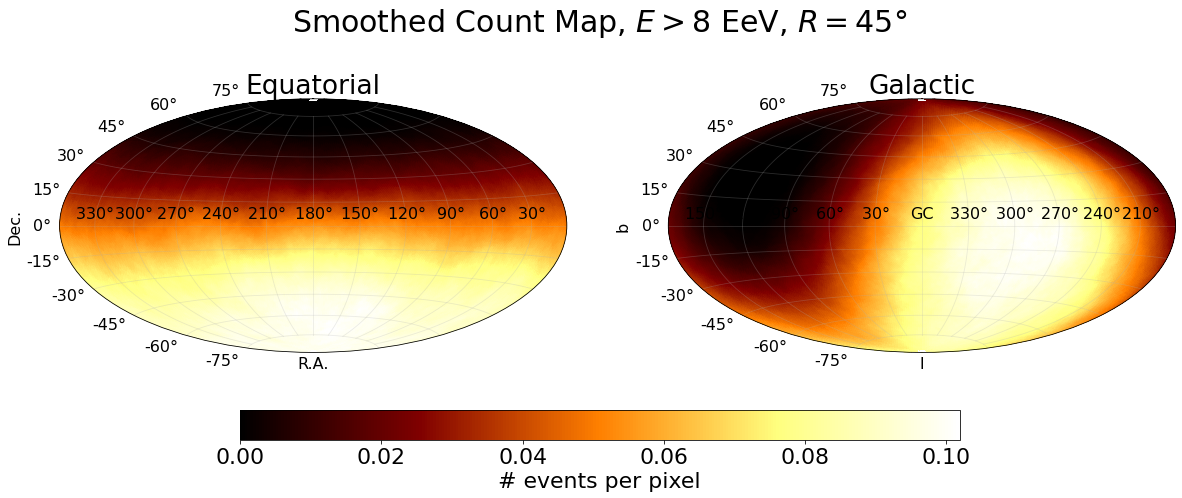

In [8]:
def top_hat_beam(radius, nside):
    
    b = np.linspace(0.0, np.pi, 10000)
    bw = np.where(abs(b) <= radius, 1, 0)
    return hp.sphtfunc.beam2bl(bw, b, lmax=nside*3) #beam in the spherical harmonics space

def LoadSmoothedMap(hp_map, radius_deg, nside):
    
    radius = np.radians(radius_deg)
    solid_angle = 2.*np.pi*(1. - np.cos(radius))
    return hp.smoothing(hp_map, beam_window=top_hat_beam(radius, nside), verbose=False) / solid_angle

# Parameters of the maps
Emin = 8 # EeV
nside = 64
radius_deg = 45 # top-hat radius in degrees


# Define title and the color bar title of the smoothed exposure map
title = f"Smoothed Exposure Map, $R={radius_deg}\\degree$"
color_bar_title = r"Exposure [$\rm km^{2} \, sr \, yr$ / pixel]"

# Plot the two exposure map
rcParams['figure.figsize'] = 20, 14 #Size of figs
fig, ax = plt.subplots(1, 2, subplot_kw={'projection': 'hammer'})
fig.suptitle(title, fontsize=30)

for galCoord in [0, 1]:
    exposure_map = LoadExposureMap(totalExposure, nside, galCoord)
    exposure_map_smoothed = LoadSmoothedMap(exposure_map, radius_deg, nside)
    image = PlotHPmap(exposure_map_smoothed, nside, galCoord, title, color_bar_title, ax=ax[galCoord], fig=fig)

fig.subplots_adjust(top=1.4)
cbar_ax = fig.add_axes([0.25, 0.55, 0.5, 0.03])
cb = fig.colorbar(image, orientation='horizontal', shrink=.6, pad=0.05, cax=cbar_ax)
cb.set_label(color_bar_title, size=22)


# Define title and the color bar title of the smoothed count map
title = f"Smoothed Count Map, $E >{Emin}$ EeV, $R = {radius_deg}\\degree$"
color_bar_title = r"# events per pixel"

# Plot the two exposure map
rcParams['figure.figsize'] = 20, 14 #Size of figs
fig, ax = plt.subplots(1, 2, subplot_kw={'projection': 'hammer'})
fig.suptitle(title, fontsize=30)

for galCoord in [0, 1]:
    
    dataset = LoadShapedData(galCoord, Emin)# data above 8 EeV
    count_map = LoadCountMap(dataset, nside)
    count_map_smoothed = LoadSmoothedMap(count_map, radius_deg, nside)
    image = PlotHPmap(count_map_smoothed, nside, galCoord, title, color_bar_title, ax=ax[galCoord], fig=fig)

fig.subplots_adjust(top=1.4)
cbar_ax = fig.add_axes([0.25, 0.55, 0.5, 0.03])
cb = fig.colorbar(image, orientation='horizontal', shrink=.6, pad=0.05, cax=cbar_ax)
cb.set_label(color_bar_title, size=22)

plt.show()


## Smoothed flux and significance maps

The flux map is obtained here as the ratio of the smoothed count and exposure maps, resulting in a flux estimate $\Phi_{\cal{R}} = \sum_{{\rm pix} \in {\cal{R}}} N_{\rm pix} /\sum_{{\rm pix} \in {\cal{R}}} \omega_{\rm pix}$, where $N_{\rm pix}$ is the number of events in a given pixel and $\omega_{\rm pix}$ the associated exposure over a region $\cal{R}$ defined as a disk of used-defined radius. It should be noted that an alternative convention could consist in estimating the flux as $\sum_{{\rm pix} \in \cal{R}} N_{\rm pix} / \omega_{\rm pix}$. Both approaches result in consistent estimates away from the border of the field of view of the Observatory. We adopt the first convention for the sake of simplicity. 

The validity of the smoothing is limited at large declinations ($\delta > 24°$ for a maximum zenith angle of 60°), above which the exposure is close to zero. To avoid divisions by zero, pixels above the maximum declination are discarded when displaying the flux map. It should be noted that along this limit about half of the smoothing disk is filled with events or with a non-zero exposure. The aim being to highlight possible dipolar features in the flux map, the latter is displayed with a diverging color map, contrarily to exposure and count maps which are displayed with sequential colormaps.

The significance of an excess, or lack, of events in a given region with respect to the rest of the sky is estimated as in Biteau J. et al. (UHECR 2018), EPJ Web of Conferences 210, 01005, https://www.epj-conferences.org/articles/epjconf/abs/2019/15/epjconf_uhecr18_01005/epjconf_uhecr18_01005.html, https://arxiv.org/abs/1905.04188. Local significances are determined with the LiMa method (Li & Ma, Astrophysical Journal, Vol. 272, www.doi.org/10.1086/161295, Eq. 17). Such local significances do not account for the scan of direction of the center of the test region.

For a single pixel, the significance is given by $\small S= \sqrt{2} \times \sqrt{N_{\rm on} \log \left[ \frac{1+\alpha}{\alpha} \big( \frac{N_{\rm on}}{N_{\rm on} + N_{\rm off}}\big) \right] + N_{\rm off} \log \left[ (1+\alpha) \big( \frac{N_{\rm off}}{N_{\rm on} + N_{\rm off}}\big) \right]} \times {\rm sign}({\rm XS})$,

where $N_{\rm on}$ corresponds to the number of events counted in the region of interest (ON region), $N_{\rm off}$ corresponds to the number of background events counted in the rest of the sky (OFF region), $\alpha$ is the ratio of the exposures of the ON and OFF regions, and where ${\rm XS} = N_{\rm on} - \alpha\times N_{\rm off}$ is the number of events in excess in the ON region with respect to the background.

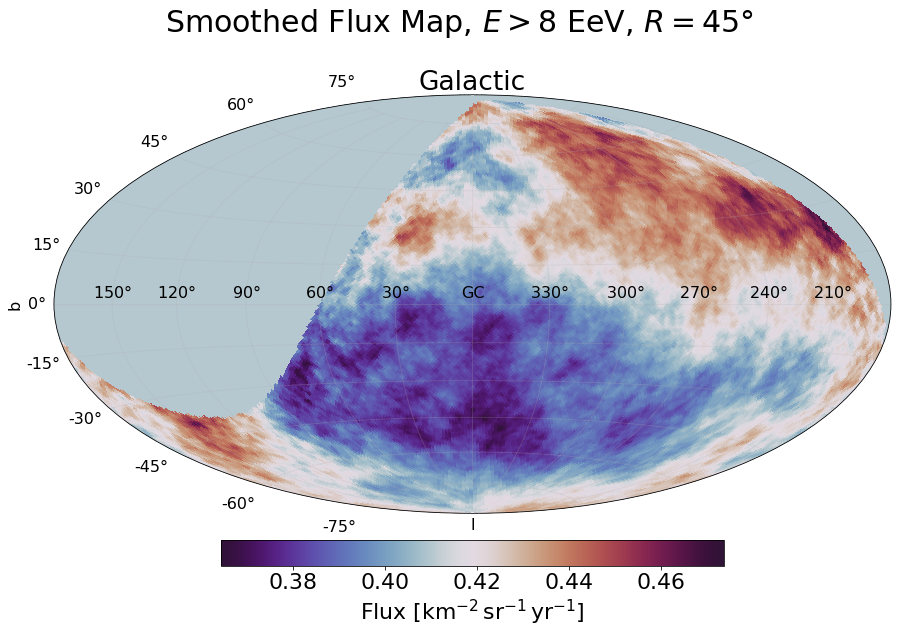

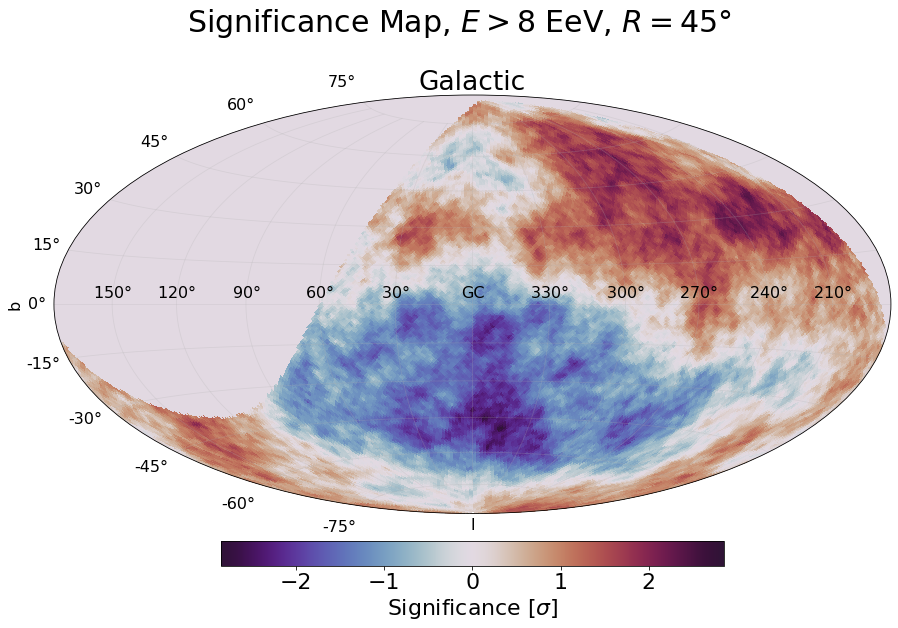

In [9]:
#LiMa significance map
def LiMaMap(nside, Non, Noff, alpha):
    Non_log_term = (1. + alpha)*Non / (alpha*(Non + Noff))
    Noff_log_term = (1. + alpha)*Noff / (Non + Noff)
    
    sig2_ov_2 = np.zeros_like(Non)
    ind = np.where((Non > 0) & (alpha > 0))# ensures non negative log terms induced by smoothing
    sig2_ov_2[ind] += Non[ind]*np.log(Non_log_term[ind])
    ind = np.where(Noff > 0)# ensures non negative log terms induced by smoothing
    sig2_ov_2[ind] += Noff[ind]*np.log(Noff_log_term[ind])

    return np.sign(Non-alpha*Noff)*np.sqrt(np.abs(2*sig2_ov_2))

# Parameters of the maps
Emin = 8 # EeV
galCoord = True
nside = 64
radius_deg = 45 # top-hat radius in degrees

# Exposure map
exposure_map = LoadExposureMap(totalExposure, nside, galCoord)
exposure_map_smoothed = LoadSmoothedMap(exposure_map, radius_deg, nside)

# Count map
dataset = LoadShapedData(galCoord, Emin) # data above 8 EeV
count_map = LoadCountMap(dataset, nside)
count_map_smoothed = LoadSmoothedMap(count_map, radius_deg, nside)

# Flux-map
flux_map = count_map_smoothed / exposure_map_smoothed 
ra, dec = Get_ra_dec(nside, galCoord)
dec_max = np.radians(24) # degrees corresponding to a 60° maximum zenith angle
flux_map[np.where(dec > dec_max)] = np.mean(flux_map[np.where(dec <= dec_max)]) #uniform above maximum dec

title = f"Smoothed Flux Map, $E > {Emin}$ EeV, $R = {radius_deg}\\degree$"
color_bar_title = r"Flux [$\rm km^{-2} \, sr^{-1} \, yr^{-1}$]"
PlotHPmap(flux_map, nside, galCoord, title, color_bar_title, cmap='twilight_shifted')

# Normalize to the total number of events in the smoothing region
solid_angle_per_pix = 4.*np.pi / hp.nside2npix(nside)
solid_angle = 2.*np.pi * (1. - np.cos(np.radians(radius_deg)))
npix_per_region = solid_angle/solid_angle_per_pix

# alpha, Non, & Noff
alpha = exposure_map_smoothed / (np.sum(exposure_map) - exposure_map_smoothed)
Non = count_map_smoothed*npix_per_region
Noff = np.sum(count_map)*npix_per_region - Non

# Significance map
sig_map = LiMaMap(nside, Non, Noff, alpha) # Compute the significance map
sig_map[np.where(dec > dec_max)] = 0 #uniform above maximum dec
max_map = np.max(np.abs(sig_map)) # Used to display a symmetric color scale
title = f"Significance Map, $E > {Emin}$ EeV, $R = {radius_deg}\\degree$"
color_bar_title = r"Significance [$\sigma$]"
PlotHPmap(sig_map, nside, galCoord, title, color_bar_title, cmap='twilight_shifted', vmin=-max_map, vmax=max_map)

The flux map appears to differ from the one published in The Pierre Auger Collaboration (2017), Science 357, 6357, 1266, https://science.sciencemag.org/content/357/6357/1266, https://arxiv.org/abs/1709.07321: with only 10% of the data, one mostly observes fluctuations due to the limited statistics.

Large-scale deviations from isotropy as function of right ascension can be further quantified, as shown in the following section.

## Rayleigh analysis in right ascension

A Rayleigh analysis in right ascension can be performed to quantify any possible large-scale anisotropy of the flux, described as $\Phi = \Phi_0 \times (1+r_\alpha\,\cos(\alpha-\alpha_0))$. The robustness of such an analysis lies in the constancy of the exposure of the Observatory as a function of right ascension. The analysis presented here is simplified with respect to that performed in The Pierre Auger Collaboration (2017), Science 357, 6357, 1266, https://science.sciencemag.org/content/357/6357/1266, https://arxiv.org/abs/1709.07321: small non-uniformities in the exposure of the array as a function of right ascension and the tilt of the array towards the south-east are not accounted for.

The Rayleigh analysis in right ascension consists in determining the amplitude, $r_\alpha$, and phase, $\phi_\alpha$, of the first-harmonic Fourier component as

$r_\alpha = \sqrt{a_\alpha^2 + b_\alpha^2}$,

$\tan \alpha_0 = b_\alpha/a_\alpha$,

where $a_\alpha = \frac{2}{N} \sum_{i=1}^{N} \cos \alpha_i$ and $b_\alpha = \frac{2}{N} \sum_{i=1}^{N} \sin \alpha_i$ and where $N$ is the number of events. The probability that an amplitude larger than $r_\alpha$ arises from isotropy can be computed as $P(r_\alpha) = \exp(-Nr_\alpha^2/4)$. 

The uncertainties of the Fourier parameters, $a_\alpha$ and $b_\alpha$, are analytical and such as $\sigma_{a_{\alpha}}=\sigma_{b_{\alpha}}=\sqrt{\frac{2}{N}}$. For the sake of simplicity, we adopt a simple propagation of the uncertainties, which yields $\sigma_{r_{\alpha}} = \sqrt{\frac{2}{N}}$ and $\sigma_{\alpha_0} = \frac{1}{r_{\alpha}}\sqrt{\frac{2}{N}}$. Note that this simple propagation of uncertainties fails for values of $a_\alpha$ and $b_\alpha$ that are compatible with zero. A full marginalization should be performed as in the above-mentioned publication to obtain refined uncertainties.

We compare below the Rayleigh approach to a $\chi^2$ difference test, where both a cosine-modulated and a constant model are fitted to the data binned in right ascension. The uncertainties on the parameters are extracted from the diagonal terms of the covariance matrix.

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

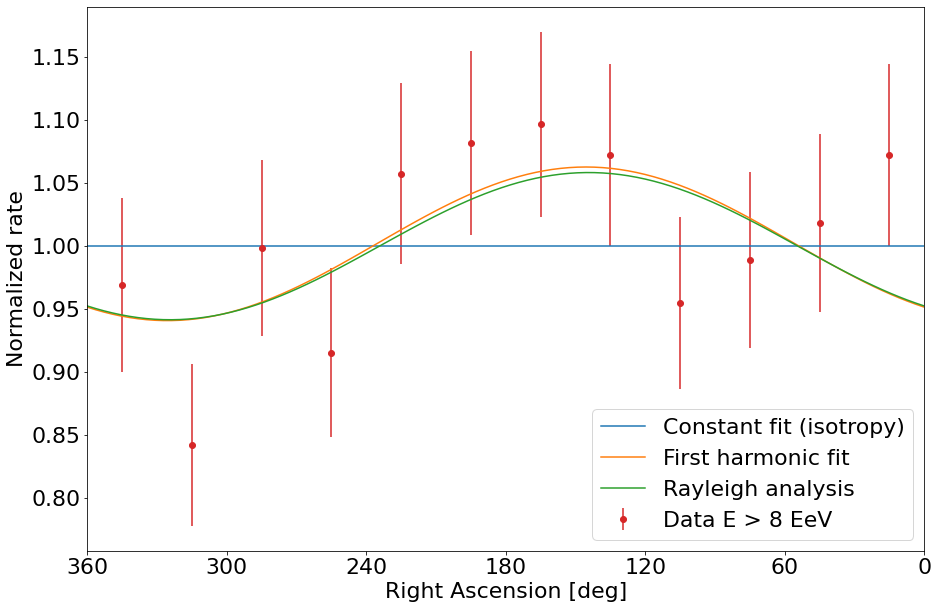

In [10]:
##### Data #############################################
def RA_Binning(ra, nbins, normalize=True):
    
    # Get the average flux, the error by binning in r.a. the flux_map
    n_bin, bin_edges = np.histogram(ra, bins=nbins)
    err_n_bin = np.sqrt(n_bin)
    ra_bin = 0.5 * (bin_edges[:-1] + bin_edges[1:])

    # Normalize to average value
    if(normalize):
        weights = 1./(err_n_bin*err_n_bin)
        average = np.sum(weights*n_bin)/np.sum(weights)
        n_bin = n_bin / average
        err_n_bin = err_n_bin / average
        
    return ra_bin, n_bin, err_n_bin

##### Fit ##############################################
def FuncConst(x, a):
    return a*np.ones_like(x)

def FuncCos(x, a, b, c):
    return (a + b*np.cos(np.radians(x)-c))

def Chi2_Const(par, args):
    x, res, err = args[0], args[1], args[2]
    return np.sum((res - FuncConst(x, par[0]))**2 / err**2)

def Chi2_Cos(par, args):
    x, res, err = args[0], args[1], args[2]
    return np.sum((res - FuncCos(x, par[0], par[1], par[2]))**2 / err**2)

def TwoSidedSignificance(prob):
    return np.sqrt(2.)*erfcinv(prob)

def FitFirstHarmonics(ra_bin, n_bin, err_n_bin):

    result_Sin, var_Sin = curve_fit(FuncCos, ra_bin, n_bin, sigma = err_n_bin, maxfev = 10000)
    err_Sin = [np.sqrt(var_Sin[i][i]) for i in range(3)]

    chi2_Sin = Chi2_Cos(result_Sin, [ra_bin,n_bin,err_n_bin])
    
    result_Const, var_Const = curve_fit(FuncConst, ra_bin, n_bin, sigma = err_n_bin, maxfev = 10000)
    chi2_Const = Chi2_Const(result_Const, [ra_bin,n_bin,err_n_bin])
    
    prob = chi2.sf(chi2_Const - chi2_Sin, df=2)
    sigma = TwoSidedSignificance(prob)
    
    display(Latex(f'''With $\chi^2$ statistics, the first harmonic is preferred at {sigma:4.1f} sigma compared to isotropy, with parameters:
    \\begin{{align}}
    \\Phi_0 &= {result_Sin[0]:0.3f} \pm {err_Sin[0]:0.3f}\\\\
    r &=  {result_Sin[1]:0.3f} \pm {err_Sin[1]:0.3f}\\\\
    \\alpha_0 &= {np.degrees(result_Sin[2]):4.0f}^\\circ \pm {np.degrees(err_Sin[2]):4.0f}^\\circ \\\\
    \\end{{align}}
    '''))
    return result_Sin, result_Const

##### Rayleigh analysis ################################
def Rayleigh(ra):
    a = 2. * np.sum(np.cos(np.radians(ra))) / ra.size
    b = 2. * np.sum(np.sin(np.radians(ra))) / ra.size
    alpha0 = np.arctan2(b,a)
    r = np.sqrt(a*a + b*b)
    
    p = np.exp(-ra.size*r*r/4.)
    sigma = TwoSidedSignificance(p)
    
    err_r = np.sqrt(2./ra.size)
    err_alpha0 = np.sqrt(2./ra.size) / r
    
    display(Latex(f'''With Rayleigh statistics, the first harmonic is preferred at {sigma:2.1f} sigma compared to isotropy, with parameters:
    \\begin{{align}}
    r &= {r:5.2} \\pm {err_r:5.2}\\\\
    \\alpha_0 &= {np.degrees(alpha0):4.0f}^\\circ \pm {np.degrees(err_alpha0):4.0f}\\\\
    \\end{{align}}
    '''))
    return r, alpha0

##### Main #############################################
# Load the dataset
Emin = 8# EeV
ra_sel = data.sd_ra[data.sd_energy > Emin]
ra_sel[ra_sel < 0] += 360. # change [-180° , 180°] to [0° , 360°]

# Rayleigh analysis
r, alpha0 = Rayleigh(ra_sel)

# Bin and fit the data
nbins = 12 #Number of bin used
ra_bin, n_bin, err_n_bin = RA_Binning(ra_sel, nbins)
resRayleigh, resConst = FitFirstHarmonics(ra_bin, n_bin, err_n_bin)

# Create the figure
width = 15# width of the figure
fig = plt.figure(figsize=(width, width/1.5))
ax = fig.add_subplot(111)
ax.set_xlabel("Right Ascension [deg]")
ax.set_ylabel("Normalized rate")
plt.xticks(np.arange(0, 360 + 1, 60))
ax.invert_xaxis()
plt.xlim(360, 0.)
    
# Plot the data
xplot = np.linspace(0, 360, 100)
ax.plot(xplot, FuncConst(xplot, resConst), label="Constant fit (isotropy)")
ax.plot(xplot, FuncCos(xplot, resRayleigh[0], resRayleigh[1], resRayleigh[2]), label="First harmonic fit")
ax.plot(xplot, FuncCos(xplot, 1, r, alpha0), label="Rayleigh analysis")
ax.errorbar(ra_bin, n_bin, yerr=err_n_bin, fmt='o', label="Data E > "+str(Emin)+" EeV")
plt.legend(loc="lower right")
plt.show()

With only events up to zenith angles of 60° and 10% of the full dataset, neither the Rayleigh analysis nor the $\chi^2$ test yield any significant deviation from isotropy.